### 1. GAN first introduction
![GAN picture](./gan.png)



GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

### 2. Define the neural networks in pytorch

In [1]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:46:43) [GCC 11.2.0]
2.5.1+cu124


Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator D:

In [2]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        # 定义两层linear以及leaky relu激活函数
        self.fc1=nn.Linear(inp_dim,256)
        self.lr1=nn.LeakyReLU(0.2)
        self.fc2=nn.Linear(256,1)
        
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        # 实现判别器
        h=self.lr1(self.fc1(x))
        out=self.fc2(h)
        out = torch.sigmoid(out)
        return out

And a small 2-layer neural network for the generator G. G takes a 100-dimensional noise vector and generates an output of the size matching the data.

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        # 定义两层linear以及leaky relu激活函数
        self.fc1=nn.Linear(z_dim,256)
        self.lr2=nn.LeakyReLU(0.2)
        self.fc2=nn.Linear(256,784)

    def forward(self, x):
        # 实现生成器
        h=self.lr2(self.fc1(x))
        out=self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [4]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (lr1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (lr2): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=256, out_features=784, bias=True)
)


Loading the data and computing forward pass

In [5]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Let's look at a sample:

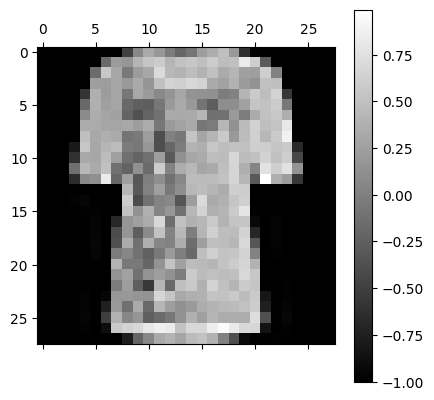

In [6]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

In [7]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.5465]], grad_fn=<SigmoidBackward0>)

In [8]:
# How you can get a batch of images from the dataloader:
# xbatch, _ = iter(dataloader).next() # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch, _ = next(iter(dataloader)) # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch.shape
D(xbatch) # 64x1 tensor: 64 predictions of probability of input being real.
D(xbatch).shape

torch.Size([64, 1])

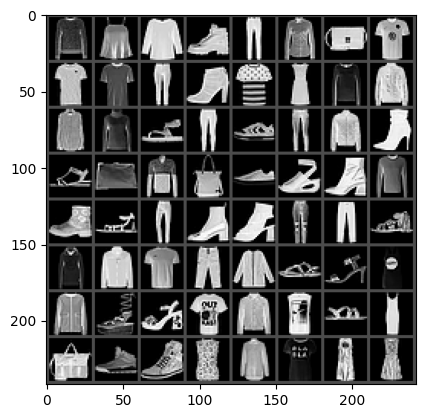

In [9]:
show_imgs(xbatch)

### 3 Intermezzo: optimization with SGD - linear regression example
We will step away from GANs for a second to introduce the core of deep learning: optimization with SGD.

Here are the core components of a basic deep learning classifier/regression setup:
* a neural network $\hat{y}=f(x, \theta)$, which takes an input $x$ and parameters $\theta$, and outputs $\hat{y}$, a prediction of label $y$.
* a loss function $\mathcal{L}(\theta) = \mathbb{E}_{x,y \sim p_d} \ell(f(x, \theta), y) \approx \sum_{x_i,y_i \sim mb} \ell(f(x_i, \theta), y_i)$.
* optimizing $\theta$ to reduce the loss, by making small updates to $\theta$ in the direction of $-\nabla_\theta \mathcal{L}(\theta)$.

pytorch is designed around these core components:
* The way to define a neural network is with `torch.nn.Module`, see how we defined the Discriminator and Generator above.
    - a `Module` defines (1) its weights and (2) defines the operations done with them.
    - initializing a module initializes the weights at random
* $\theta$ stands for all our neural network weights (everything you get from `.parameters()`)
* In the optimization loop you will evaluate a "minibatch" of samples (in our case 64) to compute the neural network output, and the loss measuring how far away those predictions are from the truth.
* To compute the gradient $\nabla_\theta \mathcal{L}(\theta)$, you call `.backward()` on the loss. This is where the magic happens: the gradient wrt all weights in the neural network is computed. They appear in a new Tensor `p.grad` for each `p in net.parameters()`
    - under the hood, this happens by keeping track of the computational graph, and reversing the computation order to "backpropagate" the loss with the chain rule.
    - [Figure which shows a bit more detail](https://tom.sercu.me/assets/201812CCNY/NN_fig.pdf)

### 3a: basic autograd example

So we said the big deal about pytorch (or other deep learning package) is **autograd = automatic differentiation** which allows to compute derivatives automatically.

Every `torch.Tensor`, let's say `x`, has an important flag `requires_grad`. If this flag is set to True, pytorch will keep track of the graph of operations that happen with this tensor.
When we finally arrive at some output (a scalar variable based on a sequence of operations on `x`), we can call `.backward()` on this output, to compute the gradient `d(output) / dx`. This gradient will end up in `x.grad`.

In [10]:
x = torch.randn(2,2, requires_grad=True)
x

tensor([[-1.1755,  0.6697],
        [ 1.7686, -0.2190]], requires_grad=True)

In [11]:
# no gradient yet at this point:
print(x.grad)

None


In [12]:
y=(x**2 + x)
z = y.sum()
z

tensor(6.0501, grad_fn=<SumBackward0>)

We know from high school math that the derivative `dz / dx[i,j]` = 2*x[i,j] +1

In [13]:
z.backward()
x.grad

tensor([[-1.3509,  2.3394],
        [ 4.5373,  0.5619]])

In [14]:
2*x+1

tensor([[-1.3509,  2.3394],
        [ 4.5373,  0.5619]], grad_fn=<AddBackward0>)

You can play with this: you can introduce any tensor operation here; for example `torch.exp(torch.sin(x**2))`. Confirm that the gradient matches the analytical derivative.

More about autograd in the tutorial https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py and the docs https://pytorch.org/docs/stable/autograd.html


This was a very basic example of what pytorch autograd does for us: computing the derivatives of a scalar function $z(x)$ wrt $x$: $\nabla_x z(x)$.
In a deep learning context this will be at the basis of our optimization; now we will have
* $\mathcal{L}(\theta)$  the loss is a (scalar) function of neural network parameters (vector) $\theta$.
* autograd will allow us to call `.backward()` on the loss, which will compute the gradient of the loss with respect to neural network parameters $\nabla_\theta \mathcal{L}(\theta)$.
* For each of the parameters `p` the gradient will be in `p.grad`
* Can you confirm that for the parameters of G/D, the flag `.requires_grad` is `True`?

In [15]:
for p in G.parameters():
    print(p.grad)

None
None
None
None


### 3b: Linear regression
Let's try this for a simple linear mapping `y = f(x, theta) = <x, theta>` with $x, \theta \in \mathbb{R}^{2}$. We we want to optimize $\theta$:

In [16]:
torch.manual_seed(23231)
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor ([3, 6, 9, -9, -6]).view(5,1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1) # 5 x 2 input. 5 datapoints, 2 dimensions.
# theta = torch.randn(1,2, requires_grad=True) # ~equal to:
theta = torch.nn.Parameter(torch.randn(1,2))
# we start theta at random initialization, the gradient will point us in the right direction.
print('x:\n', x)
print('y:\n', y)
print('theta at random initialization: ', theta)
thetatrace = [theta.data.clone()] # initial value, for logging

x:
 tensor([[ 1.0000, -1.0593],
        [ 2.0000,  1.2427],
        [ 3.0000, -0.5301],
        [-3.0000, -0.8405],
        [-2.0000, -1.6378]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
theta at random initialization:  Parameter containing:
tensor([[ 0.4849, -0.3917]], requires_grad=True)


Take a look at x and y. What is their correct (linear) relationship?

A: `y = 3 x1 + 0 x2`

Now we define a prediction as a linear mapping $\hat{y} = (X . \theta)$

We will compute the ordinary least squares objective (mean squared error):  $\mathcal{L}(\theta) = (\hat{y}(x,\theta) - y)^2$

Compute $\nabla_\theta \mathcal{L}(\theta)$, and

Move $\theta$ a small step opposite to that direction

In [17]:
ypred = x @ theta.t() # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print('ypred:\n', ypred)
loss = ((ypred-y)**2).mean() # mean squared error = MSE
print('mse loss: ', loss.item())
loss.backward()
print('dL / d theta:\n', theta.grad)
# let's move W in that direction
theta.data.add_(-0.1 * theta.grad.data)
# Now we will reset the gradient to zero.
theta.grad.zero_()
print('theta:\n', theta)
thetatrace.append(theta.data.clone()) # for logging

ypred:
 tensor([[ 0.8998],
        [ 0.4830],
        [ 1.6623],
        [-1.1254],
        [-0.3282]], grad_fn=<MmBackward0>)
mse loss:  36.57358169555664
dL / d theta:
 tensor([[-28.0458,  -6.6600]])
theta:
 Parameter containing:
tensor([[3.2895, 0.2743]], requires_grad=True)


You can re-execute this cell above a couple of times and see how $\theta$ goes close towards the optimal value of `[3,0]`.

Text(0, 0.5, 'theta[1]')

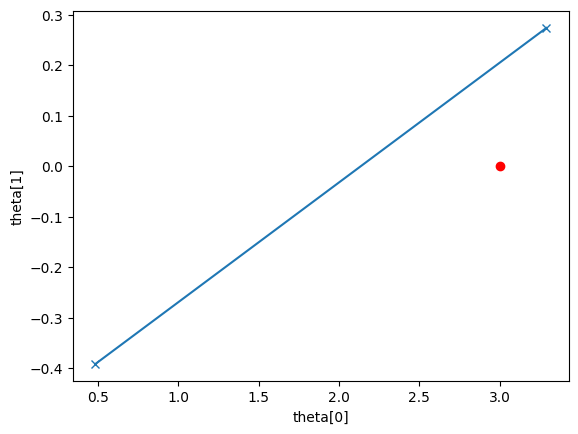

In [18]:
# Now let us plot in 2D what happened to theta during SGD optimization. In red is the true relation.
thetas = torch.cat(thetatrace, dim=0).numpy()
plt.figure()
plt.plot(thetas[:,0], thetas[:, 1], 'x-')
plt.plot(3, 0, 'ro')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')

Ok, doing this manually gives you insight what happens down to the details. But usually we do not do the gradient updates manually, it would become very cumbersome if the net becomes more complex than the simple linear layer. pytorch gives us abstractions to easily manage this complexity: 
* `nn.Linear()` (or generally  `Module`s) which do two things: (a) they contain the learnable weight, and (b) define how they operate on an input tensor to give an output.
* `module.zero_grad()` to clear the gradients, 
* `optim.SGD` with which you can do `optimizer.step()` to do a step of SGD.

In [19]:
torch.manual_seed(23801)
net = nn.Linear(2,1, bias=False)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1) # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(100): # 10 optimization steps (gradient descent steps)
    ypred = net(x)
    loss = ((ypred-y)**2).mean() # mean squared error = MSE
    optimizer.zero_grad()
    loss.backward()
    # and instead of W.data -= 0.1 * W.grad we do:
    optimizer.step()
print(net.weight)

Parameter containing:
tensor([[3.0000e+00, 1.0507e-07]], requires_grad=True)


In [20]:
class DCGenerator(nn.Module):
    def __init__(self, z_dim=100, out_channels=1, features=128):
        super(DCGenerator, self).__init__()
        self.net = nn.Sequential(
            # Input: z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, features * 4, kernel_size=7, stride=1, padding=0, bias=False),  # 4f x 7 x 7
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),
            # State: (4f) x 7 x 7
            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1, bias=False),  # 2f x 14 x 14
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),
            # State: (2f) x 14 x 14
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),  # 1 x 28 x 28
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

# DCGAN Discriminator
class DCDiscriminator(nn.Module):
    def __init__(self, in_channels=1, features=128):
        super(DCDiscriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: in_channels x 28 x 28
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),  # f x 14 x 14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),  # 2f x 7 x 7
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Final conv to scalar
            nn.Conv2d(features * 2, 1, kernel_size=7, stride=1, padding=0, bias=False),  # 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)

### 4. Back to GANs: The min-max game.
We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.


In [21]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (lr1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (lr2): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=256, out_features=784, bias=True)
)


In [22]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [23]:
# STEP 1: Discriminator optimization step
x_real, _ = next(iter(dataloader))
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

# print(D_x.mean().item(), D_G_z.mean().item())

Some things to think about / try out / investigate:
* what are the mean probabilities for real and fake? print them and see how they change when executing the cell above a couple of times. Does this correspond to your expectation?
* can you confirm how the use of the criterion maps to the objective stated above?
* when calling backward, the derivative of the loss wrt **what** gets computed?
* what does `.detach()` do? Are the Generator parameters' gradients computed?

In [24]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.5086597800254822


Again run this cell a couple of times. See how the generator increases its Discriminator score?

Some more things to ponder:
* Do the Generator parameters now receive gradients? Why (compared to previous loop)?
* From the definition of BCE loss confirm that this comes down to $-\log D(G(z))$

### Putting it all together: the full training loop

Modifications to the code:
* add device parameter to take GPU if available
* use [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) (an adaptive learning-rate variation of SGD with momentum)
* some very minimal logging

Device:  cuda
e0.i0/938 last mb D(x)=0.4832 D(G(z))=0.5016
e0.i100/938 last mb D(x)=0.9008 D(G(z))=0.3405
e0.i200/938 last mb D(x)=0.6475 D(G(z))=0.5129
e0.i300/938 last mb D(x)=0.9804 D(G(z))=0.0272
e0.i400/938 last mb D(x)=0.7214 D(G(z))=0.1737
e0.i500/938 last mb D(x)=0.6391 D(G(z))=0.2314
e0.i600/938 last mb D(x)=0.6395 D(G(z))=0.3528
e0.i700/938 last mb D(x)=0.4283 D(G(z))=0.3764
e0.i800/938 last mb D(x)=0.9397 D(G(z))=0.0942
e0.i900/938 last mb D(x)=0.9493 D(G(z))=0.0421
e1.i0/938 last mb D(x)=0.8481 D(G(z))=0.1973
e1.i100/938 last mb D(x)=0.7951 D(G(z))=0.2137
e1.i200/938 last mb D(x)=0.9045 D(G(z))=0.0861
e1.i300/938 last mb D(x)=0.9593 D(G(z))=0.0597
e1.i400/938 last mb D(x)=0.8671 D(G(z))=0.1884
e1.i500/938 last mb D(x)=0.5684 D(G(z))=0.3347
e1.i600/938 last mb D(x)=0.6868 D(G(z))=0.4012
e1.i700/938 last mb D(x)=0.4465 D(G(z))=0.6045
e1.i800/938 last mb D(x)=0.8796 D(G(z))=0.1017
e1.i900/938 last mb D(x)=0.8962 D(G(z))=0.0993
e2.i0/938 last mb D(x)=0.5636 D(G(z))=0.5214
e2.i1

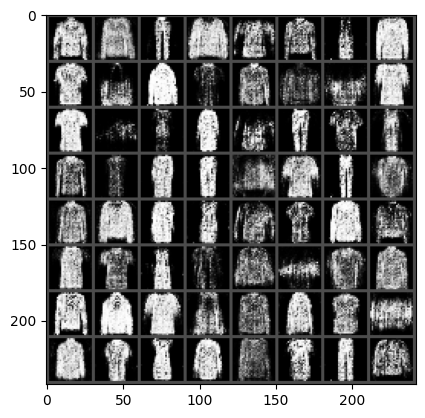

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()
loss_G=[]
loss_D=[]
# Discriminator loss 
Discriminator_loss= []
# Generator loss
Generator_loss = []
for epoch in range(30): # 3 epochs
    temp_lossD = 0
    temp_loosG = 0
    running_lossG = 0.0
    running_lossD = 0.0
    num_batches = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = next(iter(dataloader))
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        temp_lossD += lossD/len(dataloader)
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))
        temp_loosG += lossG/len(dataloader)

        lossG.backward()
        optimizerG.step()
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        num_batches += 1

    # Compute and store epoch-mean losses
        loss_D.append(running_lossD / num_batches)
        loss_G.append(running_lossG / num_batches)
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    Generator_loss.append(temp_loosG.detach().cpu().numpy())
    Discriminator_loss.append(temp_lossD.detach().cpu().numpy())
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

ValueError: x and y must have same first dimension, but have shapes (30,) and (28140,)

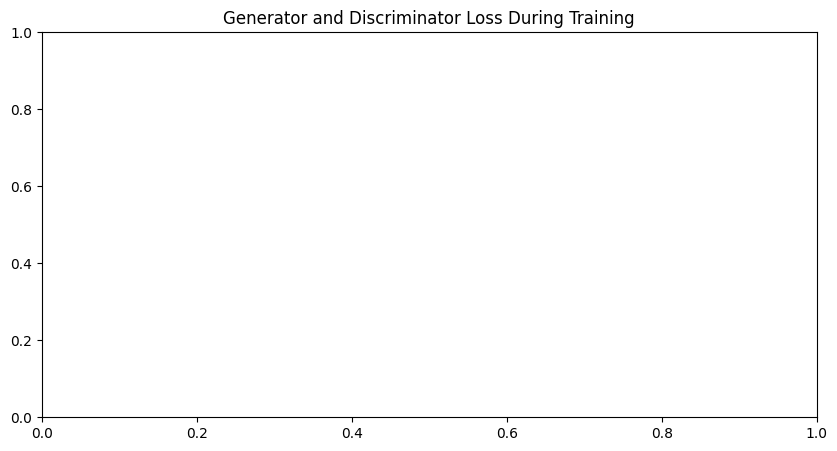

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(range(1,31,1),loss_G,label="Generator loss",color='#82989B')
plt.plot(range(1,31,1),loss_D,label="Discriminator loss",color='#BFE5E9')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("3.png")
plt.show()

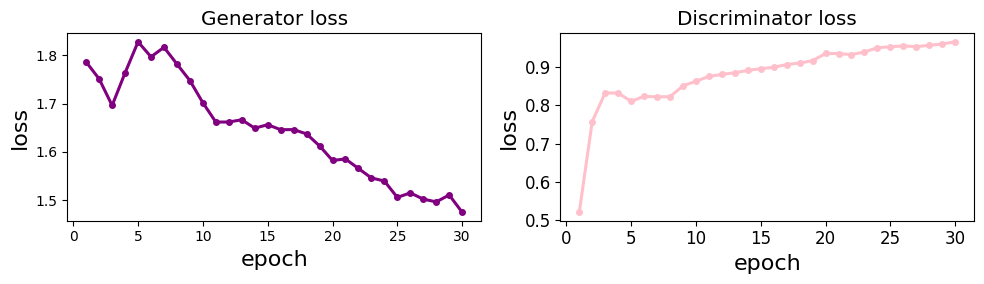

In [19]:
from matplotlib import pyplot as plt

# 设置画布大小像素点
plt.figure(figsize=(10,3),dpi=100)

# 创建第一个子图，显示 Generator loss
plt.subplot(1, 2, 1)  # 1行2列的子图中的第1个
plt.rc('font', size=12)
plt.plot(range(1,31,1), Generator_loss, marker='o',color='purple',linewidth=2.2, markersize=4)
plt.xlabel('epoch',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Generator loss')

# 创建第二个子图，显示 Discriminator loss
plt.subplot(1, 2, 2)  # 1行2列的子图中的第2个
plt.rc('font',  size=12)
plt.plot(range(1,31,1), Discriminator_loss, marker='o', color='pink',linewidth=2.2,markersize=4)  # 假设 Discriminator_loss 是你的数据
plt.xlabel('epoch',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Discriminator loss')

plt.tight_layout()  # 自动调整子图间距
plt.savefig("1.png")
plt.show()

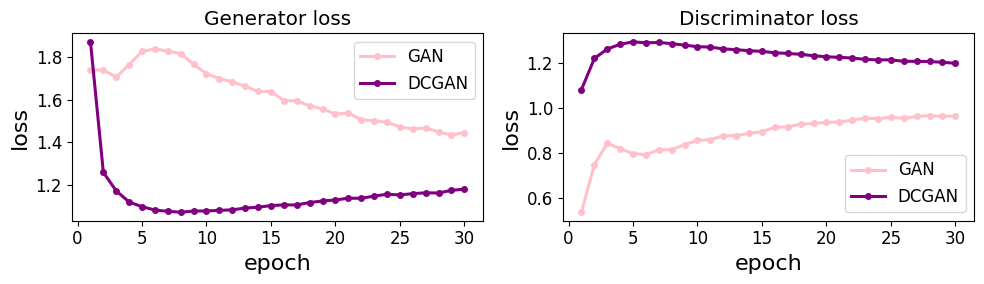

In [37]:
from matplotlib import pyplot as plt

# 设置画布大小像素点
plt.figure(figsize=(10,3),dpi=100)

# 创建第一个子图，显示 Generator loss
plt.subplot(1, 2, 1)  # 1行2列的子图中的第1个
plt.rc('font', size=12)
plt.plot(range(1,31,1), Generator_loss, marker='o',color='pink',linewidth=2.2, markersize=4,label='GAN')
plt.plot(range(1,31,1), epoch_losses_G, marker='o',color='purple',linewidth=2.2, markersize=4,label='DCGAN')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.legend()
plt.title('Generator loss')

# 创建第二个子图，显示 Discriminator loss
plt.subplot(1, 2, 2)  # 1行2列的子图中的第2个
plt.rc('font',  size=12)
plt.plot(range(1,31,1), Discriminator_loss, marker='o', color='pink',linewidth=2.2,markersize=4,label='GAN')  # 假设 Discriminator_loss 是你的数据
plt.plot(range(1,31,1), epoch_losses_D, marker='o', color='purple',linewidth=2.2,markersize=4,label='DCGAN')  
plt.xlabel('epoch',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Discriminator loss')
plt.legend()
plt.tight_layout()  # 自动调整子图间距
plt.savefig("1.png")
plt.show()

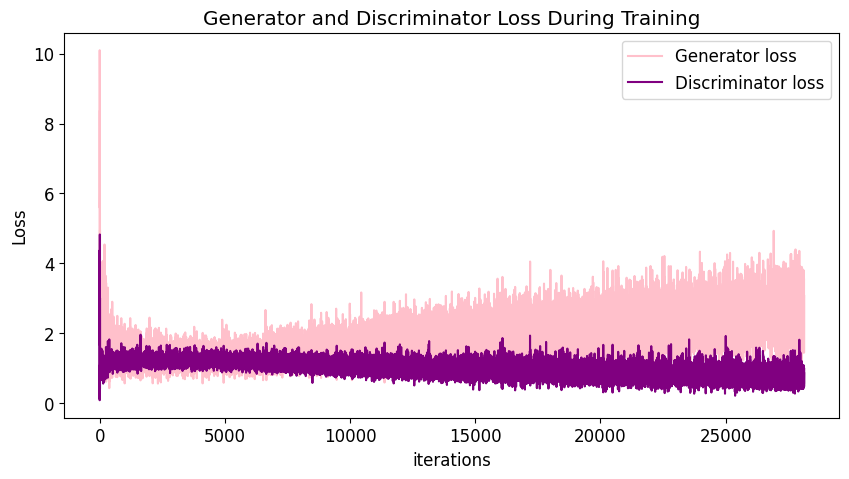

In [38]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses1,label="Generator loss",color='pink')
plt.plot(D_losses1,label="Discriminator loss",color='purple')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("2.png")
plt.show()

In [20]:
for x_gen in collect_x_g[25:30]:
    show_imgs(x_gen)

NameError: name 'collect_x_g' is not defined

In [31]:
ngf = 64 #feature map size in generator
ndf = 64 # feature map size in discriminatior
nc = 1 #number of channel
nz = 100 #size of z latent vector
num_epochs = 30
lr = 0.0002
beta1 = 0.5
ngpu = 1 #number of GPU
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [45]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters (modified for comparison)
image_size = 28
channels = 1
z_dim = 100
feature_gen = 64      # increased generator capacity
feature_disc = 64     # increased discriminator capacity
batch_size = 64
lr = 1e-3              # higher learning rate for faster convergence
beta1 = 0.5
num_epochs = 30
sample_dir = "samples"

# Ensure sample directory exists
os.makedirs(sample_dir, exist_ok=True)

# Transform: normalize to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data loader
dataset = datasets.FashionMNIST(root='data/', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# DCGAN Generator
class DCGenerator(nn.Module):
    def __init__(self):
        super(DCGenerator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Weight initialization
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Instantiate models
netG = DCGenerator().to(device)
netD = DCDiscriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# Loss and optimizers\criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for sampling
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Record per-epoch losses
epoch_losses_G = []
losses_D=[]
losses_G=[]
epoch_losses_D = []
collect_x_g=[]
print("Starting Training...")
for epoch in range(1, num_epochs + 1):
    running_lossG = 0.0
    running_lossD = 0.0
    num_batches = 0

    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        bs = imgs.size(0)

        # Real labels (1) and fake labels (0)
        real_labels = torch.ones(bs, device=device)
        fake_labels = torch.zeros(bs, device=device)

        # Train Discriminator
        netD.zero_grad()
        outputs_real = netD(imgs).view(-1) 
        D_x = outputs_real.mean().item()
        lossD_real = criterion(outputs_real, real_labels)
        noise = torch.randn(bs, z_dim, 1, 1, device=device)
        fake_imgs = netG(noise)
        outputs_fake = netD(fake_imgs.detach()).view(-1) 
        D_G_z1 = outputs_fake.mean().item()
        lossD_fake = criterion(outputs_fake, fake_labels)
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        outputs = netD(fake_imgs).view(-1) 
        D_G_z2 = outputs.mean().item()
        lossG = criterion(outputs, real_labels)
        lossG.backward()
        optimizerG.step()

        running_lossD += lossD.item()
        running_lossG += lossG.item()
        num_batches += 1

    # Compute and store epoch-mean losses
        losses_D.append(running_lossD / num_batches)
        losses_G.append(running_lossG / num_batches)
    x_gen = netG(fixed_noise)    # 而不是 G(fixed_noise)
    collect_x_g.append(x_gen.detach().cpu())
    print(D_x, D_G_z1, D_G_z2)

    print(f"Epoch {epoch:2d}: Loss D = {losses_D[-1]:.4f}, Loss G = {losses_G[-1]:.4f}")

# Plot comparison style
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, num_epochs+1), epoch_losses_G, marker='o')
ax1.set_title('Generator loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.plot(range(1, num_epochs+1), epoch_losses_D, marker='o')
ax2.set_title('DiscriminatSor loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')

plt.tight_layout()
plt.show()


Starting Training...


KeyboardInterrupt: 

In [33]:
#Method1: construct different mini batches for real and fake
img_list1 = []
G_losses1 = []
D_losses1 = []
iters = 0

for epoch in range(num_epochs):
    for i , data in enumerate(dataloader,0):
        #Update discriminator
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device) # Format batch
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1) # Forward pass real batch through D
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

       #Update generator
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses1.append(errG.item())
        D_losses1.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list1.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/30][0/938]	Loss_D: 1.6816	Loss_G: 4.0658	D(x): 0.4016	D(G(z)): 0.4937 / 0.0204
[0/30][500/938]	Loss_D: 1.1626	Loss_G: 1.3741	D(x): 0.4957	D(G(z)): 0.2665 / 0.2899
[1/30][0/938]	Loss_D: 1.2014	Loss_G: 1.5702	D(x): 0.6648	D(G(z)): 0.4935 / 0.2301
[1/30][500/938]	Loss_D: 1.1208	Loss_G: 1.5124	D(x): 0.5281	D(G(z)): 0.2993 / 0.2690
[2/30][0/938]	Loss_D: 1.2992	Loss_G: 1.0571	D(x): 0.4767	D(G(z)): 0.3223 / 0.3728
[2/30][500/938]	Loss_D: 1.1698	Loss_G: 1.0651	D(x): 0.4843	D(G(z)): 0.2971 / 0.3794
[3/30][0/938]	Loss_D: 1.2382	Loss_G: 1.0379	D(x): 0.5211	D(G(z)): 0.3561 / 0.3952
[3/30][500/938]	Loss_D: 1.4338	Loss_G: 1.6165	D(x): 0.6505	D(G(z)): 0.5865 / 0.2371
[4/30][0/938]	Loss_D: 1.2059	Loss_G: 1.1217	D(x): 0.4940	D(G(z)): 0.3176 / 0.3728
[4/30][500/938]	Loss_D: 1.2820	Loss_G: 1.3953	D(x): 0.5463	D(G(z)): 0.4320 / 0.2886
[5/30][0/938]	Loss_D: 1.5030	Loss_G: 1.3499	D(x): 0.7003	D(G(z)): 0.6381 / 0.2890
[5/30][500/938]	Loss_D: 1.1743	Loss_G: 1.0748	D(x): 0.5409	D(G(z)): 0.3576 / 0.3831
[6/3

In [29]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

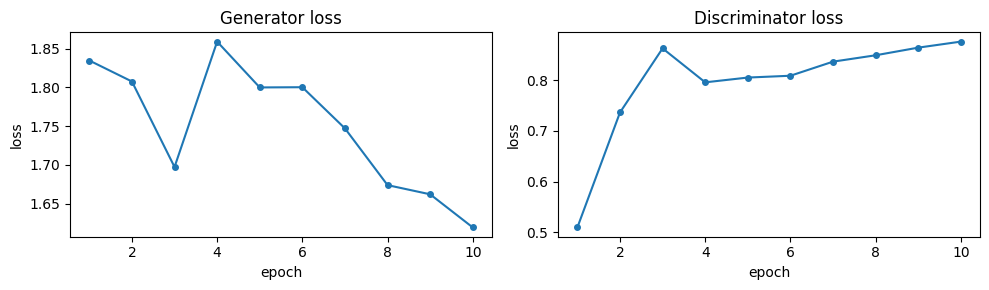

In [26]:
from matplotlib import pyplot as plt

# 设置画布大小像素点
plt.figure(figsize=(10,3),dpi=100)

# 创建第一个子图，显示 Generator loss
plt.subplot(1, 2, 1)  # 1行2列的子图中的第1个
plt.rc('font', family='SimHei', size=10)
plt.plot(range(1,11,1), Generator_loss, marker='o', markersize=4)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Generator loss')

# 创建第二个子图，显示 Discriminator loss
plt.subplot(1, 2, 2)  # 1行2列的子图中的第2个
plt.rc('font', family='SimHei', size=10)
plt.plot(range(1,11,1), Discriminator_loss, marker='o', markersize=4)  # 假设 Discriminator_loss 是你的数据
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Discriminator loss')

plt.tight_layout()  # 自动调整子图间距
plt.savefig("")
plt.show()

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len=5000, dropout_p=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_p)

        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() *
                             -(math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, hidden_size)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout_p=0.1):
        super(MultiHeadAttention, self).__init__()
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        self.linear_q = nn.Linear(hidden_size, hidden_size)
        self.linear_k = nn.Linear(hidden_size, hidden_size)
        self.linear_v = nn.Linear(hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        def split_heads(x, linear):
            x = linear(x)
            x = x.view(batch_size, -1, self.num_heads, self.head_dim)
            return x.transpose(1, 2)

        Q = split_heads(query, self.linear_q)
        K = split_heads(key,   self.linear_k)
        V = split_heads(value, self.linear_v)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        out = self.linear_out(context)
        return out, attn

class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_size, dropout_p=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(hidden_size, ff_size)
        self.linear2 = nn.Linear(ff_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_size, dropout_p=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_size, num_heads, dropout_p)
        self.cross_attn = MultiHeadAttention(hidden_size, num_heads, dropout_p)
        self.ff = FeedForward(hidden_size, ff_size, dropout_p)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.norm3 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x, enc_outputs, src_mask=None, tgt_mask=None):
        # masked self-attention
        _x, _ = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm1(x + self.dropout(_x))

        # encoder-decoder attention
        _x, attn_weights = self.cross_attn(x, enc_outputs, enc_outputs, mask=src_mask)
        x = self.norm2(x + self.dropout(_x))

        # feed-forward
        _x = self.ff(x)
        x = self.norm3(x + self.dropout(_x))
        return x, attn_weights

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, num_heads, ff_size,
                 max_len=5000, dropout_p=0.1):
        super(TransformerDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoding = PositionalEncoding(hidden_size, max_len, dropout_p)
        self.layers = nn.ModuleList([
            DecoderLayer(hidden_size, num_heads, ff_size, dropout_p)
            for _ in range(num_layers)
        ])
        self.out_proj = nn.Linear(hidden_size, vocab_size)

    def forward(self, tgt_seq, enc_outputs, src_mask=None):
        # tgt_seq: (batch, tgt_len)
        batch_size, tgt_len = tgt_seq.size()
        # create subsequent mask for auto-regressive
        tgt_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt_seq.device)).unsqueeze(0).repeat(batch_size, 1, 1)

        x = self.embedding(tgt_seq) * math.sqrt(self.hidden_size)
        x = self.pos_encoding(x)

        all_attns = []
        for layer in self.layers:
            x, attn_weights = layer(x, enc_outputs, src_mask, tgt_mask)
            all_attns.append(attn_weights)

        output = self.out_proj(x)  # (batch, tgt_len, vocab_size)
        return output, all_attns

decoder2 = TransformerDecoder(
     vocab_size=10000, hidden_size=512, num_layers=6,
     num_heads=8, ff_size=2048, max_len=5000, dropout_p=0.1
 )
tgt = torch.randint(0, 10000, (32, 20))
enc_out = torch.randn(32, 30, 512)
logits, attns = decoder(tgt, enc_out)  
